In [1]:
# global var set
import transformers

# model info, change as needed
model_checkpoint = "bert-base-uncased"
batch_size = 16
num_epochs = 16

fileTag = "clean-v1"

# Convert dataset to suitable format
IMPORTANT: please never run this section again if you have your dataset ready!

In [2]:
import pandas as pd
from pandas import DataFrame

trainDatasetOriginal = pd.read_csv(f'../../data/csv_version/dev/emotion/allcharlinepairs-{fileTag}.csv')
testDatasetOriginal = pd.read_csv(f'../../data/csv_version/test/emotion/allcharlinepairs-{fileTag}.csv')

In [3]:
trainDatasetProcessed = DataFrame({'emotion' : trainDatasetOriginal['emotion'],
                                   'plutchik' : trainDatasetOriginal['emotion'],
                                  'selection0': pd.concat([trainDatasetOriginal['sentence'][:trainDatasetOriginal.shape[0]//2], trainDatasetOriginal.sample(frac = 1).reset_index()['sentence'][trainDatasetOriginal.shape[0]//2:]]), 
                                  'selection1': pd.concat([trainDatasetOriginal.sample(frac = 1).reset_index()['sentence'][:trainDatasetOriginal.shape[0]//2], trainDatasetOriginal['sentence'][trainDatasetOriginal.shape[0]//2:]]), 
                                  'label': pd.Series(0 if x < trainDatasetOriginal.shape[0]//2 else 1 for x in trainDatasetOriginal.index)}).sample(frac=1).reset_index(drop=True)

testDatasetProcessed = DataFrame({'emotion' : testDatasetOriginal['emotion'], 
                                  'plutchik' : testDatasetOriginal['emotion'],
                                  'selection0': pd.concat([testDatasetOriginal['sentence'][:testDatasetOriginal.shape[0]//2], testDatasetOriginal.sample(frac = 1).reset_index()['sentence'][testDatasetOriginal.shape[0]//2:]]), 
                                  'selection1': pd.concat([testDatasetOriginal.sample(frac = 1).reset_index()['sentence'][:testDatasetOriginal.shape[0]//2], testDatasetOriginal['sentence'][testDatasetOriginal.shape[0]//2:]]), 
                                  'label': pd.Series(0 if x < testDatasetOriginal.shape[0]//2 else 1 for x in testDatasetOriginal.index)}).sample(frac=1).reset_index(drop=True)

In [4]:
trainDatasetProcessed.to_csv(f'./multiSelect-{fileTag}-train.csv')
trainDatasetProcessed

,emotion,selection0,selection1,label
0,"[""anxious""]",I had to hit a target.,Lisa really loved to play baseball with her br...,0
1,"[""happy""]","A few hours into her painting, a man walked by.",My mom Davey is 92 and in good health.,1
2,"[""proud"", ""creative"", ""precise ""]",Jane thought she left it at the restaurant.,Tim wrote the code for the app.,1
3,"[""frustrated""]",Chelsea immediately called the plumber to reso...,"Soon, the entrepreneurs had enough money to fu...",0
4,"[""none""]",He stopped because the therapy was not working.,I have a dog named lollipop.,1
...,...,...,...,...
53229,"[""sad""]",Rick's neighbors moved away.,The tough gal punched Sonya with all her might.,0
53230,"[""none""]","He was great with the children, and their cats.","Our granddaughter Ella lives in NYC, while we ...",1
53231,"[""afraid""]","Suddenly, an alligator appeared near the boat.",He gave her $1000 so she can catch up on her b...,0
53232,"[""confident""]",Andrew and Tom loaded up their canoes.,Patrick just walked into English class.,1


In [7]:
testDatasetProcessed.to_csv(f'./multiSelect-{fileTag}-test.csv')
testDatasetProcessed

,emotion,selection0,selection1,label
0,"[""guilty""]",Jordan's mother saw this and brought his frien...,Jim and Janie Jones had a cat named Vixen.,0
1,"[""none""]",It is her husband's sister's kid.,He wrote a book about it.,1
2,"[""none""]",The movie had sold out before we got there.,He saw the most beautiful cat there.,1
3,"[""proud"", ""happy""]",She told all her coworkers about it as she hea...,I was in shape and ready for my upcoming wedding.,1
4,"[""frustrated and angry""]",Everyone had an amazing time thanks to Carla's...,Jay couldn't find a job.,1
...,...,...,...,...
51886,"[""distrustful of roommate""]",The food was amazing there.,The roommate admitted to borrowing it.,1
51887,"[""none""]",Megan brought her little children to the park.,"After a nail biting game, the young child was ...",0
51888,"[""scare"", ""surprise""]","The next day, Kayla saw someone wearing her ne...",Felicia smiled too but her heart was still bea...,1
51889,"[""hard working""]",Gina's crush had smiled at her in the morning.,Jean went back home and continued tilling.,1


# load dataset

In [2]:
from datasets import load_dataset, load_metric

In [3]:
dataset = load_dataset('csv', data_files={'train': f'./dataset/multiSelect-{fileTag}-train.csv', 
                                           'test': f'./dataset/multiSelect-{fileTag}-test.csv'})

Using custom data configuration default-2dbc7539a11aefab
Reusing dataset csv (C:\Users\JAM_0\.cache\huggingface\datasets\csv\default-2dbc7539a11aefab\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'emotion', 'plutchik', 'selection0', 'selection1', 'label'],
        num_rows: 11610
    })
    test: Dataset({
        features: ['Unnamed: 0', 'emotion', 'plutchik', 'selection0', 'selection1', 'label'],
        num_rows: 11129
    })
})

In [5]:
dataset['test'][0]

{'Unnamed: 0': 0,
 'emotion': "['apprehensive', 'sad', 'desperate', 'annoyed', 'pressure', 'hopeful', 'trust', 'useless']",
 'plutchik': "{'joy': 0, 'trust': 0, 'fear': 1, 'surprise': 1, 'sadness': 1, 'disgust': 1, 'anger': 1, 'anticipation': 1}",
 'selection0': 'Her mom suggested she call her dad and ask for some.',
 'selection1': 'Sean knew that the noises were from a mountain lion.',
 'label': 0}

In [6]:
def show_one(example):
    print(f"Context: {example['plutchik']}")
    print(f"  A - {example['selection0']}")
    print(f"  B - {example['selection1']}")
    print(f"\nGround truth: option {['A', 'B'][example['label']]}")

In [8]:
show_one(dataset["test"][0])

Context: {'joy': 0, 'trust': 0, 'fear': 1, 'surprise': 1, 'sadness': 1, 'disgust': 1, 'anger': 1, 'anticipation': 1}
  A - Her mom suggested she call her dad and ask for some.
  B - Sean knew that the noises were from a mountain lion.

Ground truth: option A


# Preprocessing Data

In [9]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [18]:
import ast
selectionList = ["selection0", "selection1"]
weightRemap = ["NOT", "LITTLE", "", "VERY", "ABSOLUTELY"]
def preprocess_function(examples):
    # Repeat each first sentence four times to go with the four possibilities of second sentences.
    # first_sentences = [["The following sentences contain emotions: {}".format(context.strip("[").strip("]").replace('\'', '')) ]*2 for context in examples["emotion"] ]
    # first_sentences = [["The following sentences contain emotions: {}".format(context.strip("[").strip("]").replace('\"', '')) ]*2 for context in examples["plutchik"] ]
    # first_sentences = [["The following sentences contain emotions: {}".format(context.strip("[").strip("]").replace('\"', '') 
    #                   if context in {"[]", "[\"none\"]"} 
    #                   else ', '.join([(weightRemap[eachEmotion[1]] + " " +eachEmotion[0]).strip() 
    #                                   for eachEmotion in ast.literal_eval(context.replace(":", "\" : ").replace("\",", ",").replace("[", "{").replace("\"]", "}").replace("]", "}")).items()]))]*2 
    #                    for context in examples["plutchik"]]
    first_sentences = [["The following sentences contain emotions: {}".format(', '.join([(weightRemap[eachEmotion[1]] + " " +eachEmotion[0]).strip() 
                       for eachEmotion in ast.literal_eval(context).items()]))]*2 
                       for context in examples["plutchik"]]
    # Grab all second sentences possible for each context.
    second_sentences = [[examples[selection][index] for selection in selectionList]for index in range(len(examples['selection0']))]

    # Flatten everything
    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])
    
    # Tokenize
    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True)
    # Un-flatten
    # print(tokenized_examples.items())
    return {k: [v[i:i+2] for i in range(0, len(v), 2)] for k, v in tokenized_examples.items()}

In [19]:
examples = dataset["test"][:5]
features = preprocess_function(examples)
print(len(features["input_ids"]), len(features["input_ids"][0]), [len(x) for x in features["input_ids"][0]])

5 2 [44, 43]


In [20]:
[tokenizer.decode(features["input_ids"][a][i]) for a in range(5) for i in range(2) ]

['[CLS] the following sentences contain emotions : not joy, not trust, little fear, little surprise, little sadness, little disgust, little anger, little anticipation [SEP] her mom suggested she call her dad and ask for some. [SEP]',
 '[CLS] the following sentences contain emotions : not joy, not trust, little fear, little surprise, little sadness, little disgust, little anger, little anticipation [SEP] sean knew that the noises were from a mountain lion. [SEP]',
 '[CLS] the following sentences contain emotions : little joy, not trust, not fear, not surprise, not sadness, not disgust, not anger, anticipation [SEP] the other students groaned, but anna smiled. [SEP]',
 '[CLS] the following sentences contain emotions : little joy, not trust, not fear, not surprise, not sadness, not disgust, not anger, anticipation [SEP] she tried some her mom made. [SEP]',
 '[CLS] the following sentences contain emotions : joy, little trust, not fear, not surprise, not sadness, not disgust, not anger, ver

In [16]:
encoded_datasets = dataset.map(preprocess_function, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

In [17]:
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer

model = AutoModelForMultipleChoice.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

In [96]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-emotionCommonsense",
    evaluation_strategy = "epoch",
    # learning_rate=5e-8, # for bert-base
    learning_rate=1e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    push_to_hub=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [97]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch

@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [[{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        
        # Un-flatten
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        # Add back labels
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [98]:
accepted_keys = ["input_ids", "attention_mask", "label"]
features = [{k: v for k, v in encoded_datasets["train"][i].items() if k in accepted_keys} for i in range(10)]
batch = DataCollatorForMultipleChoice(tokenizer)(features)

In [99]:
[tokenizer.decode(batch["input_ids"][8][i].tolist()) for i in range(2)]

['[CLS] the following sentences contain emotions : not joy, not trust, not fear, little surprise, little sadness, disgust, little anger, not anticipation [SEP] it was much dimmer, but jane accepted it. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 "[CLS] the following sentences contain emotions : not joy, not trust, not fear, little surprise, little sadness, disgust, little anger, not anticipation [SEP] wade's trash was still sitting in the garage. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"]

In [100]:
show_one(dataset["train"][8])

Context: {'joy': 0, 'trust': 0, 'fear': 0, 'surprise': 1, 'sadness': 1, 'disgust': 2, 'anger': 1, 'anticipation': 0}
  A - It was much dimmer, but Jane accepted it.
  B - Wade's trash was still sitting in the garage.

Ground truth: option B


# Trainer Defined

In [101]:
import numpy as np

valStored = []
def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    valStored.append((preds != label_ids).astype(np.float32));
    return {"accuracy": (preds == label_ids).astype(np.float32).mean().item()}

In [102]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_datasets["train"],
    eval_dataset=encoded_datasets["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer),
    compute_metrics=compute_metrics,
)

In [103]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: emotion, Unnamed: 0, plutchik, selection1, selection0. If emotion, Unnamed: 0, plutchik, selection1, selection0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
C:\Python\miniconda3\envs\pytorchEnvWithDataSci\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11610
  Num Epochs = 16
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11616


Epoch,Training Loss,Validation Loss,Accuracy
1,0.703100,0.693147,0.496810


Saving model checkpoint to bert-base-uncased-finetuned-emotionCommonsense\checkpoint-500
Configuration saved in bert-base-uncased-finetuned-emotionCommonsense\checkpoint-500\config.json
Model weights saved in bert-base-uncased-finetuned-emotionCommonsense\checkpoint-500\pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-emotionCommonsense\checkpoint-500\tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-emotionCommonsense\checkpoint-500\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: emotion, Unnamed: 0, plutchik, selection1, selection0. If emotion, Unnamed: 0, plutchik, selection1, selection0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 11129
  Batch size = 16


KeyboardInterrupt: 

出现validation loss 上升情况大多是训练集验证集数据分布不一致，或者训练集过小，未包含验证集中所有情况，
也就是过拟合导致的。而解决这种现象可以尝试以下几种策略：
1. 增加训练样本增加正则项系数权重，
2. 减小过拟合加入早停机制，ValLoss上升几个epoch直接停止
3. 采用Focal Loss
4. 加入Label Smoothing

# Store Value

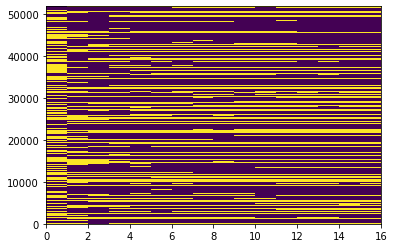

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

Z = np.transpose(valStored)

fig, ax = plt.subplots()
ax.pcolormesh(Z)

In [23]:
import pandas as pd
dataLog = pd.DataFrame(trainer.state.log_history)
dataLog.to_csv(f'./trainingMetric/[plutchik]trainingInfo-{fileTag}.csv')

In [24]:
evaluationIterationResult = pd.DataFrame(np.transpose(valStored))
evaluationIterationResult.to_csv(f'./trainingMetric/[plutchik]evaluationSpecificInfo-{fileTag}.csv')